In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk import word_tokenize, ngrams
from sklearn import ensemble
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
import xgboost as xgb

eng_stopwords = set(stopwords.words('english'))
color = sns.color_palette()

%matplotlib inline

#pd.options.mode.chained_assignment = None  # default='warn'

/Users/srimi/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")
print(train_df.shape)
print(test_df.shape)

TypeError: parser_f() got an unexpected keyword argument 'decode'

In [36]:
train_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


#### print len(train_df[ train_df['is_duplicate'] == 1 ])
###### 0 -> 255027
###### 1 -> 149263

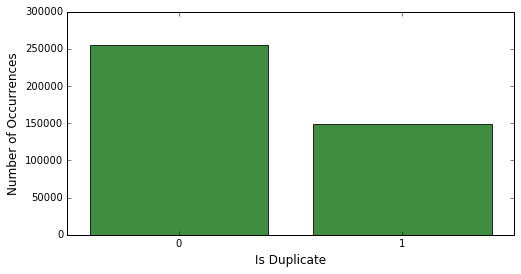

In [37]:
is_dup = train_df['is_duplicate'].value_counts()

plt.figure(figsize=(8,4))
sns.barplot(is_dup.index, is_dup.values, alpha=0.8, color=color[1])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Is Duplicate', fontsize=12)
plt.show()

In [38]:
all_ques_df = pd.DataFrame(pd.concat([train_df['question1'], train_df['question2']]))
all_ques_df.columns = ["questions"]

all_ques_df["num_of_words"] = all_ques_df["questions"].apply(lambda x : len(str(x).split()))

In [39]:
all_ques_df.head()

,questions,num_of_words
0,What is the step by step guide to invest in sh...,14
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,8
2,How can I increase the speed of my internet co...,14
3,Why am I mentally very lonely? How can I solve...,11
4,"Which one dissolve in water quikly sugar, salt...",13


In [40]:
str(all_ques_df["questions"][3])

'3    Why am I mentally very lonely? How can I solve...\n3    Find the remainder when [math]23^{24}[/math] i...\nName: questions, dtype: object'

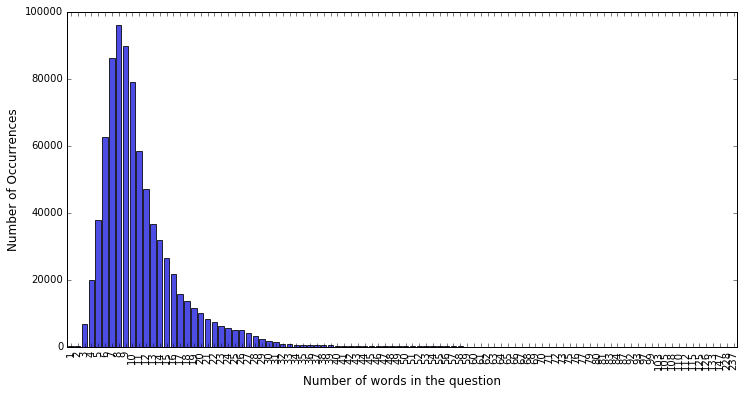

In [41]:
cnt_srs = all_ques_df['num_of_words'].value_counts()

plt.figure(figsize=(12,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[0])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of words in the question', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

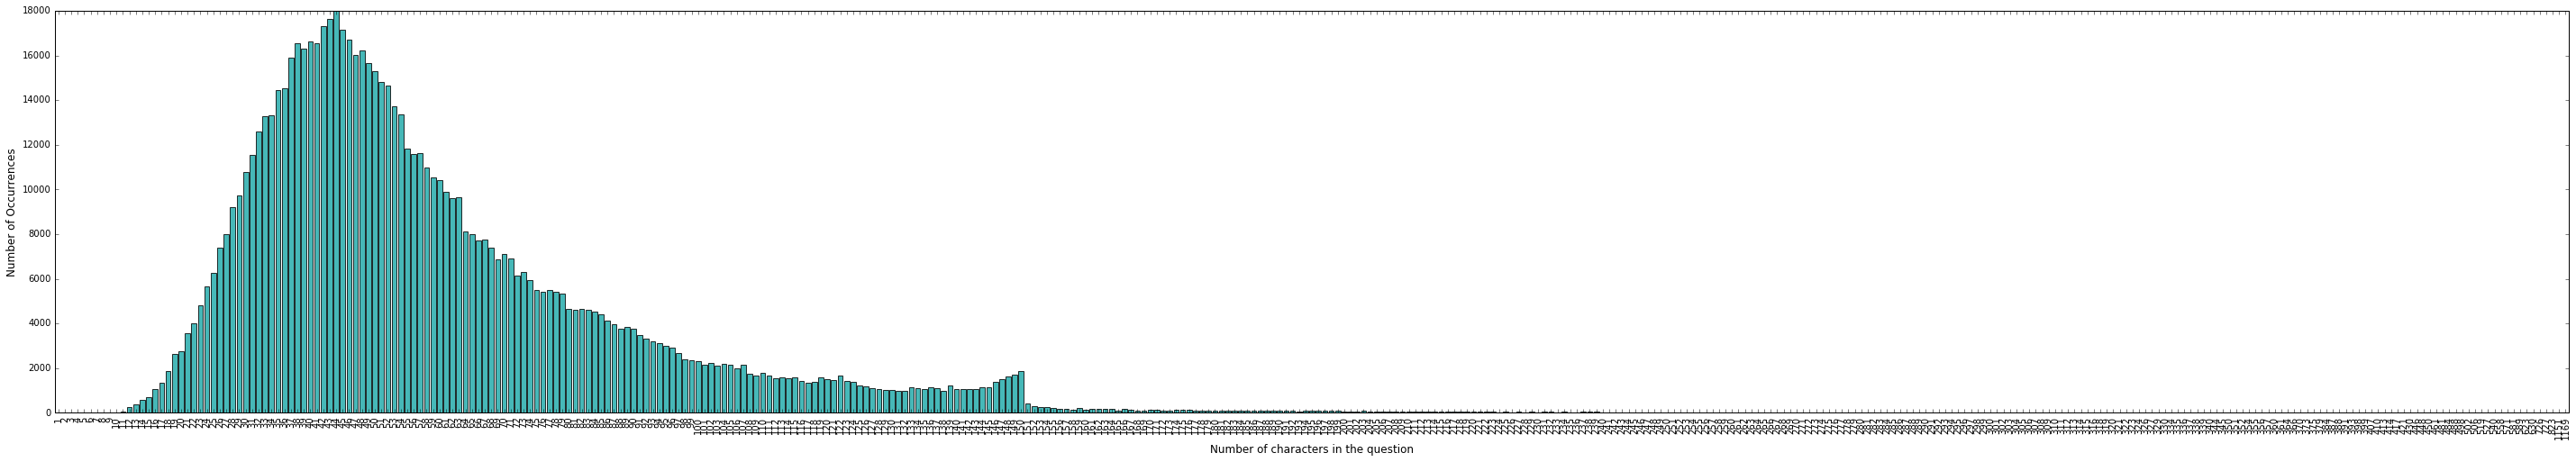

In [42]:
all_ques_df["num_of_chars"] = all_ques_df["questions"].apply(lambda x : len(str(x)))
cnt_srs = all_ques_df['num_of_chars'].value_counts()

plt.figure(figsize=(50,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[3])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of characters in the question', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

In [43]:
all_ques_df.head()

,questions,num_of_words,num_of_chars
0,What is the step by step guide to invest in sh...,14,66
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,8,51
2,How can I increase the speed of my internet co...,14,73
3,Why am I mentally very lonely? How can I solve...,11,50
4,"Which one dissolve in water quikly sugar, salt...",13,76


In [44]:
max(cnt_srs)

18000

In [65]:
def get_unigrams(que):
    return [word for word in word_tokenize(que.lower()) if word not in eng_stopwords]

def get_common_unigrams(row):
    return len( set(row["unigrams_ques1"]).intersection(set(row["unigrams_ques2"])) )

def get_common_unigram_ratio(row):
    return float(row["unigrams_common_count"]) / max(len( set(row["unigrams_ques1"]).union(set(row["unigrams_ques2"])) ),1)

train_df["unigrams_ques1"] = train_df['question1'][0:1000].apply(lambda x: get_unigrams(str(x)))
train_df["unigrams_ques2"] = train_df['question2'][0:1000].apply(lambda x: get_unigrams(str(x)))
train_df["unigrams_common_count"] = train_df[0:1000].apply(lambda row: get_common_unigrams(row),axis=1)
train_df["unigrams_common_ratio"] = train_df[0:1000].apply(lambda row: get_common_unigram_ratio(row), axis=1)


In [66]:
train_df['question1'][1:4]

1    What is the story of Kohinoor (Koh-i-Noor) Dia...
2    How can I increase the speed of my internet co...
3    Why am I mentally very lonely? How can I solve...
Name: question1, dtype: object

In [67]:
train_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,unigrams_ques1,unigrams_ques2,unigrams_common_count,unigrams_common_ratio
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,"[step, step, guide, invest, share, market, ind...","[step, step, guide, invest, share, market, ?]",6.0,0.857143
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,"[story, kohinoor, (, koh-i-noor, ), diamond, ?]","[would, happen, indian, government, stole, koh...",6.0,0.461538
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,"[increase, speed, internet, connection, using,...","[internet, speed, increased, hacking, dns, ?]",3.0,0.300000
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,"[mentally, lonely, ?, solve, ?]","[find, remainder, [, math, ], 23^, {, 24, }, [...",1.0,0.062500
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,"[one, dissolve, water, quikly, sugar, ,, salt,...","[fish, would, survive, salt, water, ?]",3.0,0.200000


In [68]:
all_ques_df.head()

,questions,num_of_words,num_of_chars
0,What is the step by step guide to invest in sh...,14,66
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,8,51
2,How can I increase the speed of my internet co...,14,73
3,Why am I mentally very lonely? How can I solve...,11,50
4,"Which one dissolve in water quikly sugar, salt...",13,76


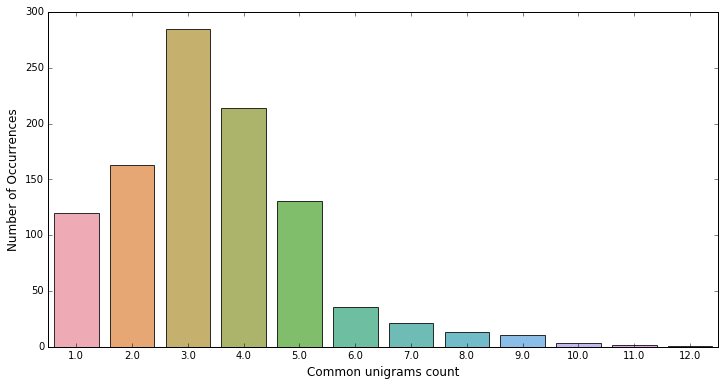

In [69]:
cnt_srs = train_df['unigrams_common_count'].value_counts()

plt.figure(figsize=(12,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Common unigrams count', fontsize=12)
plt.show()
